In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import re
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib import patches
import os

In [13]:
data_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df = pd.read_csv(os.path.join(data_folder, 'merged_dataset.csv'))
df.head()

industry_papers = df[df['company_affiliation'] > df['university_affiliation']]
academia_papers = df[df['university_affiliation'] > df['company_affiliation']]


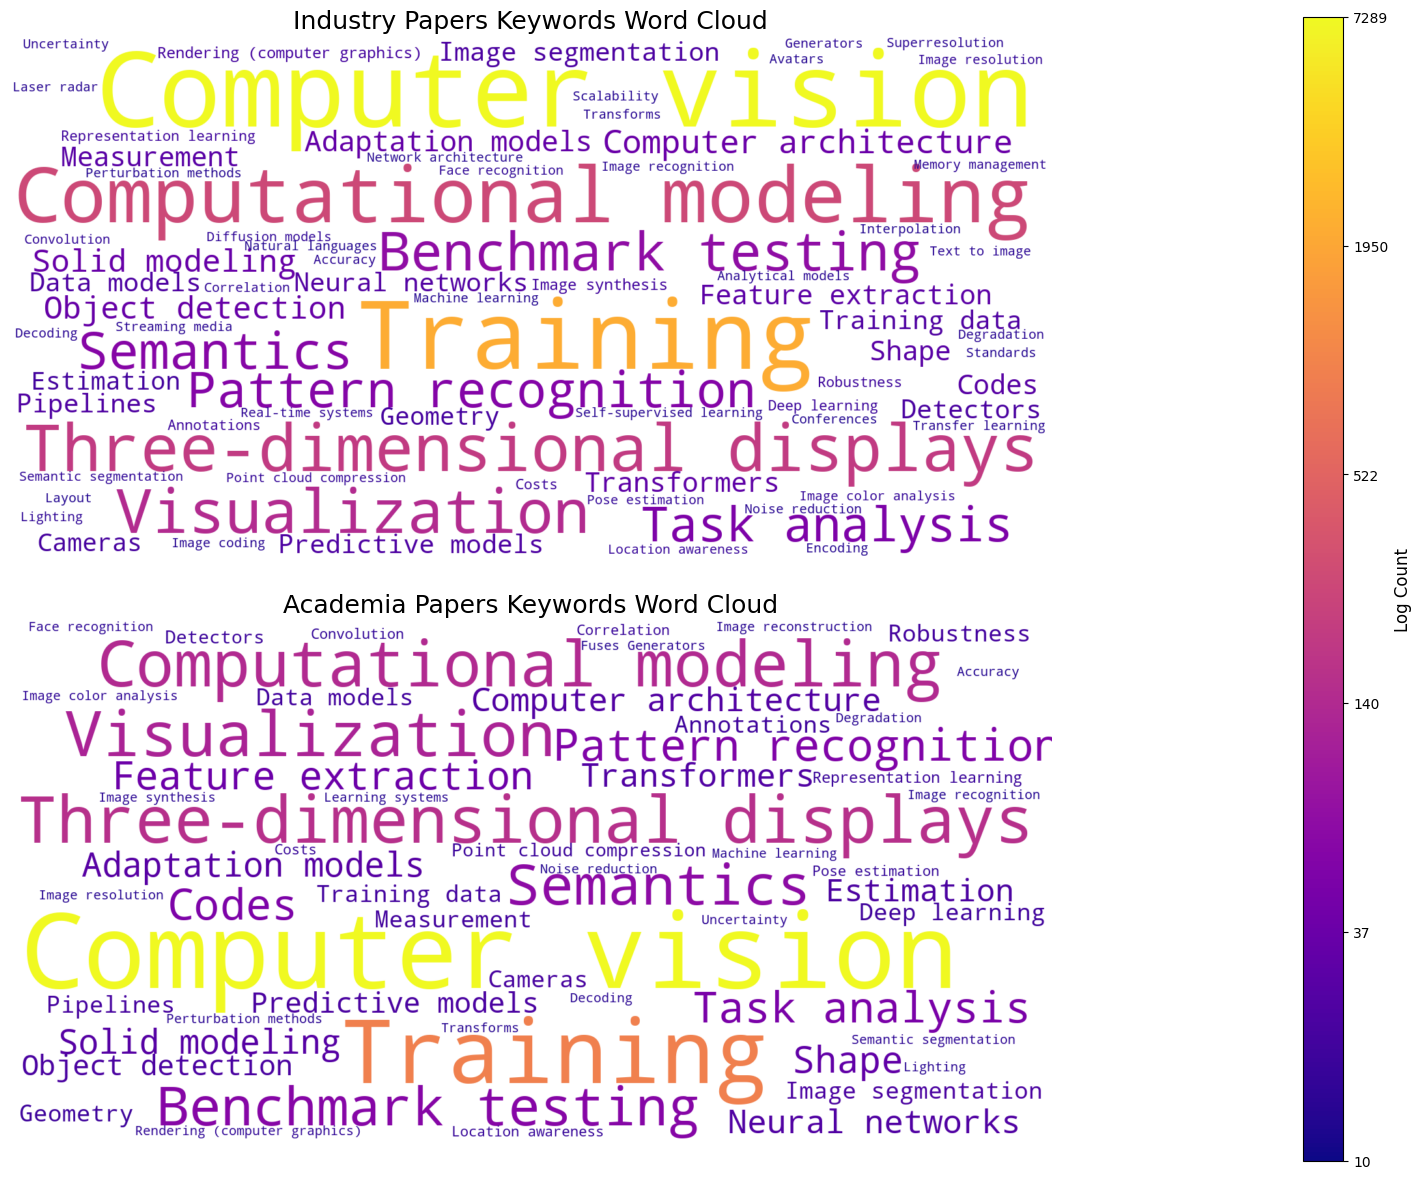

In [41]:
def clean_and_count_keywords(keyword_series):
    all_keywords = []
    for keywords in keyword_series:
        if isinstance(keywords, str):  # If string, split and clean
            cleaned_keywords = [re.sub(r'[\'\"\[\]]', '', kw.strip()) for kw in keywords.split(',')]
            all_keywords.extend(cleaned_keywords)
    return Counter(all_keywords)

# Clean and count keywords
cleaned_industry_keywords = clean_and_count_keywords(industry_papers['ieee_keywords'])
cleaned_academia_keywords = clean_and_count_keywords(academia_papers['ieee_keywords'])

# Shared color function based on frequency
def frequency_color_func(word, counter):
    max_count = max(counter.values())
    frequency = counter[word]
    normalized_freq = frequency / max_count  # Normalize between 0 and 1
    cmap = cm.plasma  # Use a colormap
    rgba_color = cmap(normalized_freq)
    return mcolors.to_hex(rgba_color)

# Function to generate word cloud
def generate_word_cloud(counter, title, ax):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        color_func=lambda word, **kwargs: frequency_color_func(word, counter),  # Color by frequency
        max_words=100,
        prefer_horizontal=1,  # More horizontal words
        min_font_size=10,
        max_font_size=80,  # Control font size for spacing
        scale=2,  # Improve resolution
    ).generate_from_frequencies(counter)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=18)

# Create a gradient legend
def add_gradient_legend(fig, position, max_count):
    cmap = cm.plasma
    norm = plt.Normalize(vmin=1, vmax=np.log10(max_count))  # Log scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=position, orientation='vertical')
    cbar.set_label("Log Count", fontsize=12)
    cbar.set_ticks(np.linspace(1, np.log10(max_count), 6))
    cbar.set_ticklabels([f"{10**x:.0f}" for x in np.linspace(1, np.log10(max_count), 6)])

# Plot word clouds and legends
fig = plt.figure(figsize=(16, 12))

# Word clouds
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
generate_word_cloud(cleaned_industry_keywords, "Industry Papers Keywords Word Cloud", ax1)

ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
generate_word_cloud(cleaned_academia_keywords, "Academia Papers Keywords Word Cloud", ax2)

# Add gradient legend
cax = plt.subplot2grid((2, 3), (0, 2), rowspan=2, colspan=1)  # Space for the vertical legend
cax.set_aspect(10)  # Increase aspect ratio to make the legend thin and long

add_gradient_legend(fig, cax, max(max(cleaned_industry_keywords.values()), max(cleaned_academia_keywords.values())))

plt.tight_layout()
plt.show()